**Use on-demand test objective functions (e.g. bimodal) to help calibrate surrogate functions and acquisition functions**

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from output import format_for_submission
import csv

In [58]:
random.seed(51)
np.random.seed(51)

def get_function_data(function_number):
    ary_in = np.load(f'../data/raw/initial_data/function_{function_number}/initial_inputs.npy')
    ary_out = np.load(f'../data/raw/initial_data/function_{function_number}/initial_outputs.npy')

    week1_out = [0.0, -0.03634716524130564, -0.13995571712281177, -11.512791229057324, 351.7115420928652, -0.5971511450896173, 0.2910786825809617, 8.618272750952901]
    week1_in = [np.array([0.00367, 0.9999 ]), 
                np.array([0.851999, 0.973204]), 
                np.array([0.747032, 0.28413 , 0.226329]), 
                np.array([0.169128, 0.756136, 0.275457, 0.528761]), 
                np.array([0.439601, 0.772709, 0.376277, 0.933269]), 
                np.array([0.232204, 0.132714, 0.53824 , 0.760706, 0.075595]), 
                np.array([0.476821, 0.248196, 0.242816, 0.576157, 0.162416, 0.290926]), 
                np.array([0.221603, 0.703755, 0.674607, 0.130295, 0.376739, 0.669444, 0.136655, 0.061316])]    
    
    week2_out = [-1.2075460499722905e-18, 0.17608630702211278, -0.17239781799687137, -31.982880235497266, 1236.8846557000643, -2.451406055102475, 0.00010805707939840242, 5.178959940699899]
    week2_in = [np.array([0.476035, 0.572563]), 
                np.array([0.641846, 0.498841]), 
                np.array([0., 0., 0.]), 
                np.array([0.953433, 0.895217, 0.812477, 0.618719]), 
                np.array([0.987523, 0.470227, 0.946409, 0.105412]), 
                np.array([3.40696e-01, 4.94179e-01, 2.10000e-05, 3.08050e-02, 9.39958e-01]), 
                np.array([0.88314 , 0.756642, 0.      , 0.      , 0.9     , 0.942719]), 
                np.array([0.993634, 0.968223, 0.979285, 0.397318, 0.965856, 0.955218, 0.006078, 0.024001])]

    week3_out = [-2.118633970077695e-95, -0.1068943462941895, -0.005838531351604155, -2.6718044713157307, 32.0025, -1.4580645404618957, 0.4892165178828796, 9.9417237968706]

    week3_in = [np.array([0.127849, 0.198491]), 
                np.array([0.246077, 0.656597]), 
                np.array([0.492581, 0.611593, 0.5     ]), 
                np.array([0.510358, 0.521985, 0.383995, 0.445439]), 
                np.array([0.5, 0.5, 0.5, 0.5]), 
                np.array([0.66336 , 0.      , 0.999999, 0.332984, 0.      ]), 
                np.array([0.      , 0.165185, 0.28681 , 0.      , 0.318109, 0.999999]), 
                np.array([0.119265, 0.254466, 0.117275, 0.24563 , 0.548426, 0.553172,  0.230111, 0.516062])]

    ary_out=np.append(ary_out, week1_out[function_number-1])
    ary_out=np.append(ary_out, week2_out[function_number-1])
    ary_out=np.append(ary_out, week3_out[function_number-1])
    ary_in=np.vstack((ary_in, week1_in[function_number-1]))
    ary_in=np.vstack((ary_in, week2_in[function_number-1]))
    ary_in=np.vstack((ary_in, week3_in[function_number-1]))
    
    return ary_in, ary_out

class FunctionInfo():
    rbf_lengthscales = [0.8, 0.001, 0.016, 0.337, 0.0162, 0.68, 0.644, 1.0 ] # functions 2 and 8 didn't find optimal lengthscale in training
    ucb_kappas = [1.4, 1.1, 0.6, 0.8, 0.4, 0.8, 0.8, 0.8] # only got successful calibration for first 3. Default to 0.8 for the rest (high because still exploring) - except function 5 which is unimodal so can exploit more.
    def __init__(self, function_number):
        self.function_number = function_number
        self.rbf_lengthscale = self.rbf_lengthscales[function_number - 1]
        self.ucb_kappa = self.ucb_kappas[function_number - 1]


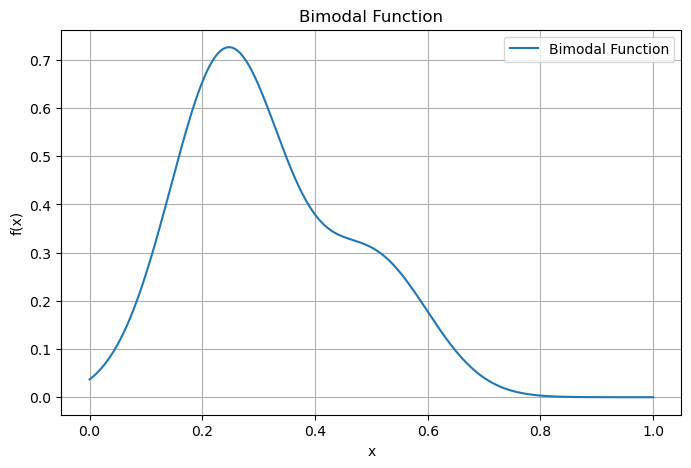

Max from grid search: 0.7262285252538603


In [3]:
#Test bimodal function
class one_d_test:
    # Parameters for the two Gaussian peaks
    #mu1 is x of first peak
    #mu2 is x of second peak TODO: experiment with 0.02-0.2
    #Sigmas are widths of peaks
    #alpha1 is weight of first peak (default 1)
    #alpha2 is weight of second peak (default 0.5)

    sigma1 = 0.1
    sigma2 = 0.1
    mu1 = 0.3
    mu2 = 0.7
    alpha1 = 1
    alpha2 = 0.5

    def __init__(self, sigma1=0.1, sigma2=0.1, mu1=0.3, mu2=0.7, alpha1=1, alpha2=0.5):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    def call_function(self, x): 
        # Calculate the two Gaussian components
        gaussian1 = np.exp(-((x - self.mu1) ** 2) / (2 * self.sigma1 ** 2))
        gaussian2 = np.exp(-((x - self.mu2) ** 2) / (2 * self.sigma2 ** 2))
        gaussian1 = self.alpha1 * gaussian1
        gaussian2 = self.alpha2 * gaussian2
        
        # Combine and normalize to keep the output between 0 and 1
        result = (gaussian1 + gaussian2) / (self.alpha1 + self.alpha2)
        return result

# Test the function with a range of values
x = np.linspace(0, 1, 500)
testmu1 = random.random()
testmu2 = random.random()
testalpha2 = random.uniform(0.3, 0.9)
oned = one_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
y = oned.call_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Bimodal Function")
plt.title("Bimodal Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()


print("Max from grid search:", np.max(y))

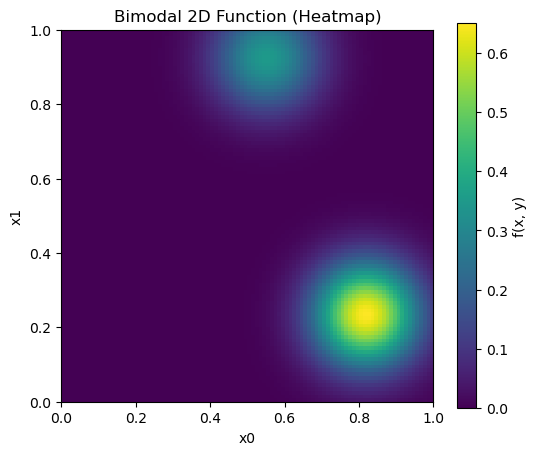

Max from grid search: 0.6496864001624209


In [4]:
class two_d_test:

    def __init__(self, sigma1=0.1, sigma2=0.1, mu1=[0.3,0.3], mu2=[0.7,0.7], alpha1=1, alpha2=0.5):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    sigma1 = 0.1
    sigma2 = 0.1
    mu1 = [0.3,0.3]
    mu2 = [0.7,0.7]
    alpha1 = 1
    alpha2 = 0.5

    def call_function(self, X):
        """
        Bimodal function f(x0, x1) in [0, 1]^2 -> [0, 1].
        X is an array of shape (N, 2).
        Returns a 1D array of length N, each element in [0, 1].
        """

        X = np.asarray(X)
        X = np.atleast_2d(X)  # Ensure X is 2D
        x0 = X[:, 0]  # shape (N,)
        x1 = X[:, 1]  # shape (N,)

        # 2D Gaussian around (mu1[0], mu1[1])
        g1 = np.exp(-(((x0 - self.mu1[0]) ** 2) / (2 * self.sigma1 ** 2)
                      + ((x1 - self.mu1[1]) ** 2) / (2 * self.sigma1 ** 2)))

        # 2D Gaussian around (mu2[0], mu2[1]) 
        g2 = np.exp(-(((x0 - self.mu2[0]) ** 2) / (2 * self.sigma2 ** 2)
                      + ((x1 - self.mu2[1]) ** 2) / (2 * self.sigma2 ** 2)))

        # Combine and normalize so max remains <= 1
        return (self.alpha1 * g1 + self.alpha2 * g2) / (self.alpha1 + self.alpha2)


def plot_twod_objective(twod):

    N = 100
    x0_vals = np.linspace(0, 1, N)
    x1_vals = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0_vals, x1_vals)        # shape (N, N) each
    X_grid = np.column_stack((X0.ravel(), X1.ravel()))  # shape (N*N, 2)

    y_grid  = twod.call_function(X_grid)
    # Reshape back to (N, N) for plotting
    y_2d = y_grid.reshape(N, N)
    
    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(y_2d, origin='lower', extent=(0,1,0,1), cmap='viridis', aspect='equal')
    plt.colorbar(label='f(x, y)')
    plt.title("Bimodal 2D Function (Heatmap)")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()

    # 3D surface
    #fig = plt.figure(figsize=(8,6))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(X0, X1, y_2d, cmap='viridis', edgecolor='none')
    #ax.set_title("Bimodal 2D Function (Surface Plot)")
    #ax.set_xlabel("x0")
    #ax.set_ylabel("x1")
    #ax.set_zlabel("f(x, y)")
    #plt.show()

    print("Max from grid search:", np.max(y_2d))



testmu1 = [random.random(),random.random()]
testmu2 = [random.random(),random.random()]
testalpha2 = random.uniform(0.3, 0.9)

twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
plot_twod_objective(twod)


In [19]:
# week 4 - extend to any number of dimensions and any number of peaks
class n_d_test:

    #def __init__(self, sigma1=0.1, sigma2=0.1, mu1=[0.3,0.3], mu2=[0.7,0.7], alpha1=1, alpha2=0.5):
    #    self.sigma1 = sigma1
    #    self.sigma2 = sigma2
    #    self.mu1 = mu1
    #    self.mu2 = mu2
    #    self.alpha1 = alpha1
    #    self.alpha2 = alpha2

    def __init__(self, sigma, mu, alpha):
        self.sigma = sigma
        self.mu = mu
        self.alpha = alpha

        assert len(sigma) == len(mu), "Sigma and mu array must have same length"
        assert len(sigma) == len(alpha), "Sigma and alpha array must have same length"
             

    # sigma: list of standard deviations
    # mu: list of mean points, each in n dimensions
    # alpha: list of peak heights

    sigma=[]
    mu=[]
    alpha=[]
    
    #sigma1 = 0.1
    #sigma2 = 0.1
    #mu1 = [0.3,0.3]
    #mu2 = [0.7,0.7]
    #alpha1 = 1
    #alpha2 = 0.5

    def call_function(self, X):
        """
        Bimodal function f(x0, x1) in [0, 1]^2 -> [0, 1].
        X is an array of shape (N, 2).
        Returns a 1D array of length N, each element in [0, 1].
        """

        X = np.asarray(X)
        if(len(X.shape)==1): # reshape 1d to 2d
            X = X.reshape(-1, 1)


        #X = np.atleast_2d(X)  # Ensure X is at least 2D
        gaussians = []
        dimensions = X.shape[1]
        #need 1 gaussian for each mu
        for m in range(len(self.mu)):
            terms = 0
            for d in range(dimensions):
                term = ((X[:, d] - self.mu[m][d]) ** 2) / (2 * self.sigma[m]**2)
                terms += term
            g = np.exp(-terms)

            gaussians.append(g)

        #normalise
        numerator = 0
        denominator = 0
        for m in range(len(self.mu)):
            numerator += (self.alpha[m] * gaussians[m])
            denominator += self.alpha[m]
        
        return numerator / denominator



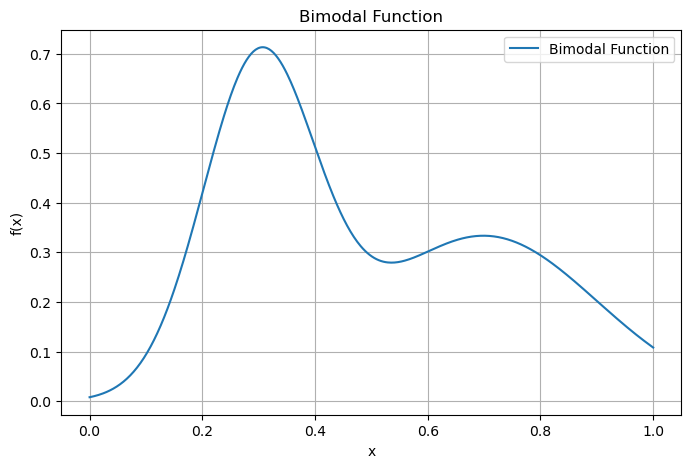

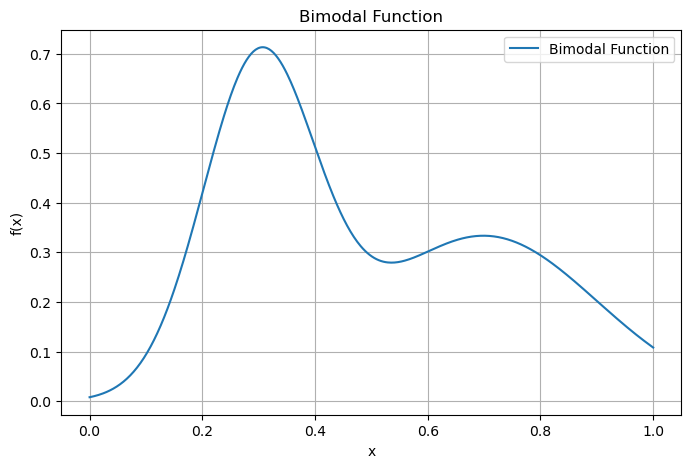

[0.34760895]
[0.34760895]


In [20]:
#week 4
#pilot test n_d by using it to plot one_d
x = np.linspace(0, 1, 500)
testmu1 = 0.3
testmu2 = 0.7
testalpha1 = 1
testalpha2 = 0.5
testsigma1 = 0.1
testsigma2 = 0.2
oned = one_d_test(sigma1 = testsigma1, sigma2 = testsigma2, mu1=testmu1, mu2=testmu2, alpha1 =testalpha1, alpha2 = testalpha2)
y = oned.call_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Bimodal Function")
plt.title("Bimodal Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

x = np.linspace(0, 1, 500)
nd = n_d_test(sigma=[testsigma1, testsigma2], mu=[[[testmu1]], [[testmu2]]], alpha=[testalpha1, testalpha2])
y = nd.call_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Bimodal Function")
plt.title("Bimodal Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

x2 = np.array([0.46])
onedy2 = oned.call_function(x2)
print(onedy2)
ndy2 = nd.call_function(x2)
print(ndy2)




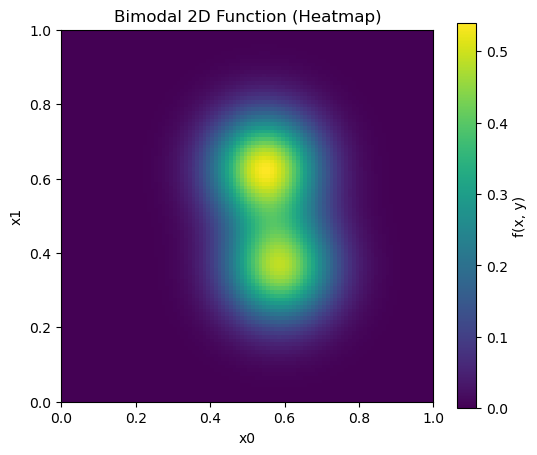

Max from grid search: 0.5391436629961787


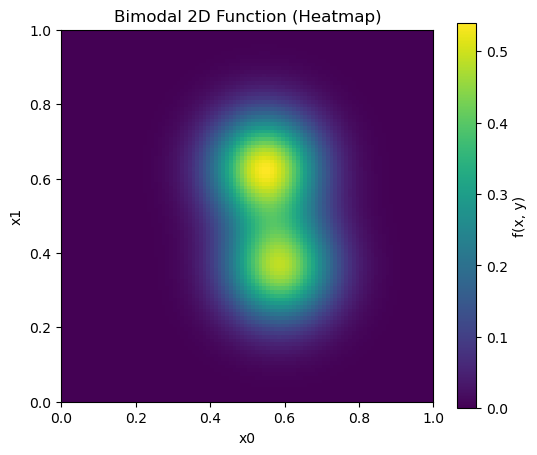

Max from grid search: 0.5391436629961787


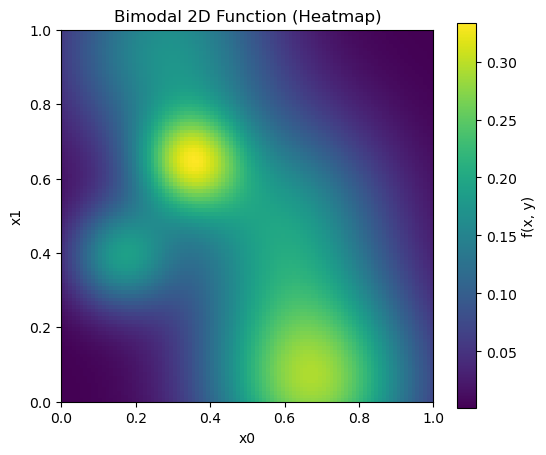

Max from grid search: 0.33303129708859497


In [21]:
#week 4
#pilot test n_d by using it to plot two_d
testmu1 = [random.random(),random.random()]
testmu2 = [random.random(),random.random()]
testalpha2 = random.uniform(0.3, 0.9)
testalpha1 = 1
twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha1 = 1, alpha2=testalpha2)
plot_twod_objective(twod)

nd = n_d_test(mu = [testmu1, testmu2], sigma=[0.1,0.1], alpha = [testalpha1, testalpha2] )
plot_twod_objective(nd)

# try 5 peaks
mu5 = np.random.rand(5,2)
sigma5 = (0.2, 0.1, 0.2, 0.1, 0.2)
nd5 = n_d_test(mu=mu5, alpha=(1, 0.8,0.6, 0.6, 0.6), sigma = sigma5)
plot_twod_objective(nd5)

In [23]:
# Test acquisition functions on the 1d function

noise_assumption = 1e-10 # noise assumption, a hyper-parameter

input_bounds = [(0, 1)] # bounds for the input space

#Experiment with lengthscale 0.1 to 0.5 in steps of 0.05
# and kappa 0.1 to 3 in steps of 0.1

def input_bounds_for_dim(dimensions):
    return [(0, 1) for _ in range(dimensions)]

def bounds_midpoint(input_bounds):
    return np.array([(low + high) / 2.0 for low, high in input_bounds])

def acquisition_UCB(x, model, ucb_kappa):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return mean + ucb_kappa * std

def test_on_oned(rbf_lengthscale, ucb_acquisition_kappa, test_oned_function, max_iterations):
    
    objective_x = np.linspace(0, 1, 500)
    objective_y = test_oned_function.call_function(objective_x)
    objective_y_max = max(objective_y)

    #quick plot objective function
    #plt.figure(figsize=(3, 5))
    #plt.plot(objective_x, objective_y, label="Objective")
    #plt.grid(True)
    #plt.legend()
    #plt.show()

    kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    X = []
    Y = []
    # First point
    x0 = bounds_midpoint(input_bounds)  # array([0.5])
    X.append(x0)
    Y.append(test_oned_function.call_function(x0))
    i=0
    #print("Objective max:", objective_y_max)
    while abs(max(Y) - objective_y_max) > 0.01:
        i+=1
        if i > max_iterations:
            print("Max iterations reached")
            return 0
        #print("Iteration", i, " Max found:", max(Y))
        # print(abs(max(Y) - objective_y_max))
        # fit the model
        model.fit(X, Y)
            
        # optimize the acquisition function
        result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=bounds_midpoint(input_bounds), bounds=input_bounds)
        x_new = result.x
        y_new = test_oned_function.call_function(x_new)
        
        # add the new observation to the training set
        X.append(x_new) #assumes 1d
        Y.append(y_new)

    return i

def plot_oned_objective(oned):
    objective_x = np.linspace(0, 1, 500)
    objective_y = oned.call_function(objective_x)
    plt.figure(figsize=(3, 3))
    plt.plot(objective_x, objective_y, label="Objective")
    plt.grid(True)
    plt.show()



In [25]:
def output_results_csv(number_of_functions, results, filename="out"):
    headers = ["Lengthscale", "Acq kappa"]
    for i in range(number_of_functions):
        headers.append("Function " + str(i))
    with open(f'{filename}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(results)

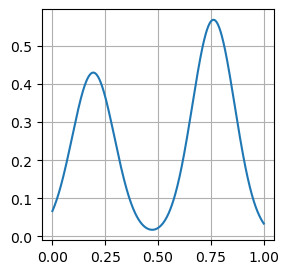

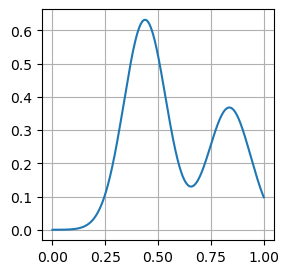

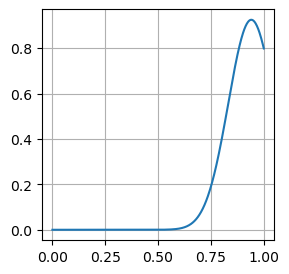

Lengthscale: 0.05
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Kappa: 0.6
Kappa: 0.7
Max iterations reached
Kappa: 0.8
Kappa: 0.9
Kappa: 1.0
Kappa: 1.1
Kappa: 1.2
Kappa: 1.3
Kappa: 1.4
Kappa: 1.5
Kappa: 1.6
Kappa: 1.7
Kappa: 1.8
Kappa: 1.9
Lengthscale: 0.1
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Kappa: 0.6
Kappa: 0.7
Kappa: 0.8
Kappa: 0.9
Kappa: 1.0
Kappa: 1.1
Kappa: 1.2
Kappa: 1.3
Kappa: 1.4
Kappa: 1.5
Kappa: 1.6
Kappa: 1.7
Kappa: 1.8
Kappa: 1.9
Lengthscale: 0.15000000000000002
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Kappa: 0.6
Kappa: 0.7
Kappa: 0.8
Kappa: 0.9
Kappa: 1.0
Kappa: 1.1
Kappa: 1.2
Kappa: 1.3
Kappa: 1.4
Kappa: 1.5
Kappa: 1.6
Kappa: 1.7
Kappa: 1.8
Kappa: 1.9
Lengthscale: 0.2
Kappa: 0.1
Max iterations reached
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Kappa: 0.6
Kappa: 0.7
Kappa: 0.8
Kappa: 0.9
Kappa: 1.0
Kappa: 1.1
Kappa: 1.2
Max iterations reached
Kappa: 1.3
Kappa: 1.4
Kappa: 1.5
Kappa: 1.6
Kappa: 1.7
Max iterations reached
Kappa: 1.

In [26]:
#ucb_kappa = 3
#rbf_lengthscale = 0.2 # lengthscale parameter
test_functions = []
for i in range(3):
    testmu1 = random.random()
    testmu2 = random.random()
    testalpha2 = random.uniform(0.3, 0.9)
    oned = one_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(oned)
    plot_oned_objective(oned) # to see what we're dealing with

results = []
for rbf_lengthscale in np.arange(0.05, 0.25, 0.05):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.1):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        for oned in test_functions:
            iterations_required = test_on_oned(rbf_lengthscale, ucb_kappa, oned, 20)
            fn_result.append(iterations_required)
            #print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            fn+=1
        results.append(fn_result)

output_results_csv(len(test_functions), results)

In [ ]:
#test on 2d functions
twod_input_bounds = [(0, 1), (0,1)]
def test_on_twod(rbf_lengthscale, ucb_acquisition_kappa, test_twod_function, max_iterations):
    
    N = 100
    x0_vals = np.linspace(0, 1, N)
    x1_vals = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0_vals, x1_vals)        # shape (N, N) each
    objective_x = np.column_stack((X0.ravel(), X1.ravel()))  # shape (N*N, 2)
    objective_y = test_twod_function.call_function(objective_x)
    objective_y_max = max(objective_y)

    kernel = RBF(length_scale=rbf_lengthscale)
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    X = []
    Y = []
    # First point
    initial_x = bounds_midpoint(twod_input_bounds)  # array([0.5])
    X.append(initial_x)
    Y.append(test_twod_function.call_function(initial_x))
    for i in range(5):
        starting_x = [random.random(), random.random()]
        starting_y = test_twod_function.call_function(starting_x)
        X.append(starting_x)
        Y.append(starting_y)
    
    i=0

    #print("Objective max:", objective_y_max)
    while abs(max(Y) - objective_y_max) > 0.01:
        i+=1
        # print("Max y:", max(Y))
        if i > max_iterations:
            print("Max iterations reached")
            return 0
        #print("Iteration", i, " Max found:", max(Y))
        # print(abs(max(Y) - objective_y_max))
        # fit the model
        model.fit(X, Y)
            
        # optimize the acquisition function
        result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=initial_x, bounds=twod_input_bounds)
        x_new = result.x
        y_new = test_twod_function.call_function(x_new)
        
        # add the new observation to the training set
        X.append(x_new)
        Y.append(y_new)

    return i

test_functions = []
for i in range(3): #5
    testmu1 = [random.random(),random.random()]
    testmu2 = [random.random(),random.random()]
    testalpha2 = random.uniform(0.3, 0.9)
    twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(twod)
    plot_twod_objective(twod) # to see what we're dealing with

#test_on_twod(0.15, 0.4, test_functions[0], 20)

results = []
for rbf_lengthscale in np.arange(0.05, 0.5, 0.05):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.1):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        for twod in test_functions:
            iterations_required = test_on_twod(rbf_lengthscale, ucb_kappa, twod, 20)
            fn_result.append(iterations_required)
            print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            fn+=1
        results.append(fn_result)

#print(results)
output_results_csv(len(test_functions), results)


from the output, lengthscale 0.25 kappa 0.3 was about best for 2d

for 1d, lengthscale 0.15 kappa 0.4


In [56]:
# week 4 - set up test profiles to test the higher dimensions

#Generate a random data point between 0 and 1 for the number of dimensions
def random_point(dimensions):
    return np.random.rand(dimensions)

class TestProfile():
    def __init__(self, dimensions, start_samples, maxima, std = 0.1):
        self.dimensions = dimensions
        self.start_samples = start_samples # number of samples to start with
        self.maxima = maxima
        self.std = std

    def CreateFunctions(self, number):
        profile_functions = []
        for i in range(number):
            mu = []
            # assume 0.1 std for all gaussians
            # assume alpha (relative height) = 1 for first peak and 0.5 for others
            sigma = [self.std] * self.maxima
            alpha = [1]

            for m in range(self.maxima):
                mu.append(random_point(self.dimensions))
                if(m > 0):
                    alpha.append(0.5)
            ndt = n_d_test(mu=mu, sigma=sigma, alpha=alpha)
            profile_functions.append (ndt)
        return profile_functions

def get_test_profile(function_number):
    X, Y = get_function_data(function_number)
    # Return a test profile matching what we know about the objective function
    # Function 1 (2d): 2 maxima
    # Function 2 (2d): "a lot of local optima" - use small standard deviation (0.05) and 10 peaks
    # Function 4 (4d): "a lot of local optima" - use small standard deviation (0.05) and 20 peaks
    # Function 5 (4d): 1 maximum
    # For other functions - use the number of dimensions as the number of peaks
    dimensions = X.shape[1]
    start_samples = X.shape[0]
    maxima = dimensions
    std = 0.15
    if(function_number == 1):
        maxima = 2
    elif(function_number ==2):
        std = 0.1
        maxima=10
    elif(function_number == 4):
        std = 0.05
        maxima=20
    elif(function_number==5):
        maxima=1

    return TestProfile(dimensions, start_samples, maxima, std)


def test_on_n_d(test_profile: TestProfile, rbf_lengthscale, ucb_acquisition_kappa, test_function: n_d_test, max_iterations, n_grid = 20):
    
    # 1. Create a list of coordinate arrays, one for each dimension.
    coords_1d = [np.linspace(0, 1, n_grid) for _ in range(test_profile.dimensions)]

    # 2. Create the D-dimensional mesh.
    #    Each element of `mesh` will be an array of shape (N, N, ..., N) [D times].
    mesh = np.meshgrid(*coords_1d, indexing='ij')

    # 3. Flatten each dimension, then stack them to get shape (N^D, D).
    #    .ravel() flattens the array, and column_stack collects them into columns.
    objective_x = np.column_stack([m.ravel() for m in mesh])

    objective_y = test_function.call_function(objective_x)
    objective_y_max = max(objective_y)

    kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds=(0.001, 1))
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    X = []
    Y = []
    # First point
    bounds = input_bounds_for_dim(test_profile.dimensions)
    initial_x = bounds_midpoint(bounds)  
    #X.append(initial_x)
    #Y.append(test_function.call_function(initial_x))
    for i in range(test_profile.start_samples):
        starting_x = random_point(test_profile.dimensions)
        starting_y = test_function.call_function([starting_x])
        X.append(starting_x)
        Y.append(starting_y[0])
    
    i=0
    #print("Objective max:", objective_y_max)
    while abs(max(Y) - objective_y_max) > 0.01:
        i+=1
        # print("Max y:", max(Y))
        if i > max_iterations:
            #print("Max iterations reached")
            return np.nan, np.nan
        #print("Iteration", i, " Max found:", max(Y))
        # print(abs(max(Y) - objective_y_max))
        # fit the model
        model.fit(X, Y)
            
        # optimize the acquisition function
        result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=initial_x, bounds=bounds)
        x_new = result.x
        y_new = test_function.call_function([x_new])
        
        # add the new observation to the training set
        X.append(x_new)
        Y.append(y_new[0])
    trained_length_scale = 0
    if hasattr(model, "kernel_"):
        trained_length_scale = model.kernel_.length_scale
    # print (trained_length_scale)
    return i, trained_length_scale



In [19]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def build_d_dimensional_data(D, N):
    """
    Build a synthetic dataset (X, Y) in D dimensions.
    X will be a grid of size (N^D, D), each dimension going from 0 to 1.
    Y can be any function you like; here we use a simple sum of coordinates.
    """
    # 1. Create a list of 1D coordinates, one for each dimension
    coords_1d = [np.linspace(0, 1, N) for _ in range(D)]
    
    # 2. Use meshgrid to get a D-dimensional grid
    mesh = np.meshgrid(*coords_1d, indexing='ij')  # each entry shape: (N, N, ..., N) (D times)
    
    # 3. Flatten each dimension array and stack into shape (N^D, D)
    X = np.column_stack([m.ravel() for m in mesh])
    
    # 4. Define Y. For demonstration, let's do something simple, e.g. sum of all coords
    #    You could replace this with a more interesting function or use real data.
    Y = np.sum(X, axis=1)
    
    return X, Y

# ----------------------------------
# Example usage: Choose D between 3 and 8
# ----------------------------------
D = 3   # 3, 4, 5, ... up to 8
N = 10  # 10 points per dimension => total points = 10^3 = 1000 in 3D

# 1. Build synthetic dataset in D dimensions
X, Y = build_d_dimensional_data(D, N)
print("X shape:", X.shape)  # expect (N^D, D) -> (1000, 3) if D=3

# 2. Create and fit the Gaussian Process Regressor
rbf_lengthscale = 1.0
noise_assumption = 1e-6
kernel = RBF(length_scale=rbf_lengthscale)

gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_assumption)
gpr_model.fit(X, Y)

# 3. Make predictions (example: pick some random points in D dims)
X_test = np.random.rand(5, D)
Y_pred = gpr_model.predict(X_test)
print("X_test:\n", X_test)
print("Predictions:\n", Y_pred)

X shape: (1000, 3)
X_test:
 [[0.06308766 0.81953415 0.46026217]
 [0.67925475 0.71999372 0.59743582]
 [0.58757175 0.79637326 0.59175062]
 [0.40117177 0.83902438 0.20180416]
 [0.23469205 0.13637766 0.82744886]]
Predictions:
 [1.34291251 1.99664011 1.97565671 1.44201319 1.1985455 ]


In [57]:

#tp1 = get_test_profile(1)
#tf1 = tp1.CreateFunctions(1)[0]
#iterations1 = test_on_n_d(tp1, 0.3, 1.00, tf1, 10)

#tp3 = get_test_profile(3)
#tf3 = tp3.CreateFunctions(1)[0]
#iterations3 = test_on_n_d(tp3, 0.3, 1.00, tf3, 10)

# Result of running a test on a single test function
class FunctionTestResult():
    def __init__(self, iterations, test_function_number):
        self.iterations = iterations
        self.test_function_number = test_function_number
      

class FunctionTestResults():
    results = []
    def __init__(self, competition_function_number, params_description):
        self.competition_function_number = competition_function_number
        self.params_description = params_description

    def append(result:FunctionTestResult):
        results.append(result)


for fn in range(1, 9): # for each competition function
    test_profile = get_test_profile(fn) #create the test profile
    test_functions = []
    test_functions = test_profile.CreateFunctions(4) #create gaussian process simulations
    results = []
    rbf_lengthscale = FunctionInfo(fn).rbf_lengthscale # previously trained lengthscales from competition function data
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 1.5, 0.1): # for kappa in range...
        ucb_kappa = round(kappa, 2)
        #print("Kappa:", ucb_kappa)
        result_line = []
        result_line.append(rbf_lengthscale)
        result_line.append(ucb_kappa)
        for test_function in test_functions: # Test the acquisition function configuration on each simulation
            (iterations_required, trained_length_scale) = test_on_n_d(test_profile, rbf_lengthscale, ucb_kappa, test_function, 30, n_grid=20)
            result_line.append(iterations_required)
            #result_line.append(trained_length_scale)
            #print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
        results.append(result_line)

    #print(results)
    output_results_csv(len(test_functions), results, f"Function_{fn}")

Lengthscale: 0.8


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.001


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: 

Lengthscale: 0.016


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepro

Lengthscale: 0.337


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The op

Lengthscale: 0.0162


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaus

Lengthscale: 0.68


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The op

Lengthscale: 0.644


KeyboardInterrupt: 

In [61]:
# cutdown version that uses sample data instead of the initial random 5 and calls to the objective function, and suggests next point to explore.
# Use that to do week 3 submissions.
# Then, next week, start fitting on functions that are closer to the real ones in terms of local maxima/variance.

def suggest_next(rbf_lengthscale, ucb_acquisition_kappa, function_num):
    kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds=(0.001, 1))
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)
    X, Y = get_function_data(function_num)
    dimensions = X.shape[1]
    bounds = input_bounds_for_dim(dimensions)
    initial_x = bounds_midpoint(bounds)
    
    model.fit(X, Y)

    result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=initial_x, bounds=bounds)
    return result.x, model.kernel_.length_scale


for i in range(1,9):
    print("Function", i)
    info = FunctionInfo(i)
    sn, ls = suggest_next(info.rbf_lengthscale, info.ucb_kappa, i)
    formatted = format_for_submission(sn)
    print(formatted)
    #print("Trained length scale", ls)

Function 1
0.240010-0.357107
Function 2


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.500000-0.500000
Function 3
0.500000-0.500000-0.500000
Function 4
0.549669-0.508442-0.413776-0.413008
Function 5
0.500051-0.500051-0.500051-0.500051
Function 6
0.563405-0.000000-0.831340-1.000000-0.000000
Function 7
0.000000-0.626234-0.280125-0.000000-0.367770-0.451863
Function 8


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.275027-0.304704-0.160147-0.328388-0.419169-0.578759-0.436166-0.614079
